In [1]:
from typing import List

import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy import linalg, spatial, special
from scipy.special import expit as logistic
from scipy.special import logit

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = (
    polls[(polls.dateelection == "2017-04-23") & (polls.date >= "2017-01")]
    .drop(
        [
            "type",
            "dateelection",
            "abstention",
            "undecided",
        ],
        axis=1,
    )
    .set_index(["date", "sondage", "samplesize"])
    .sort_index()
)

In [4]:
# Note: no green party here
COORDS = {
    "parties": ["farleft", "left", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "center",
        "right",
        "farright",
        "other",
    ],
}

In [5]:
# compute "other" category
polls = polls.rename(
    columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")}
)[COORDS["parties"]]
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index()

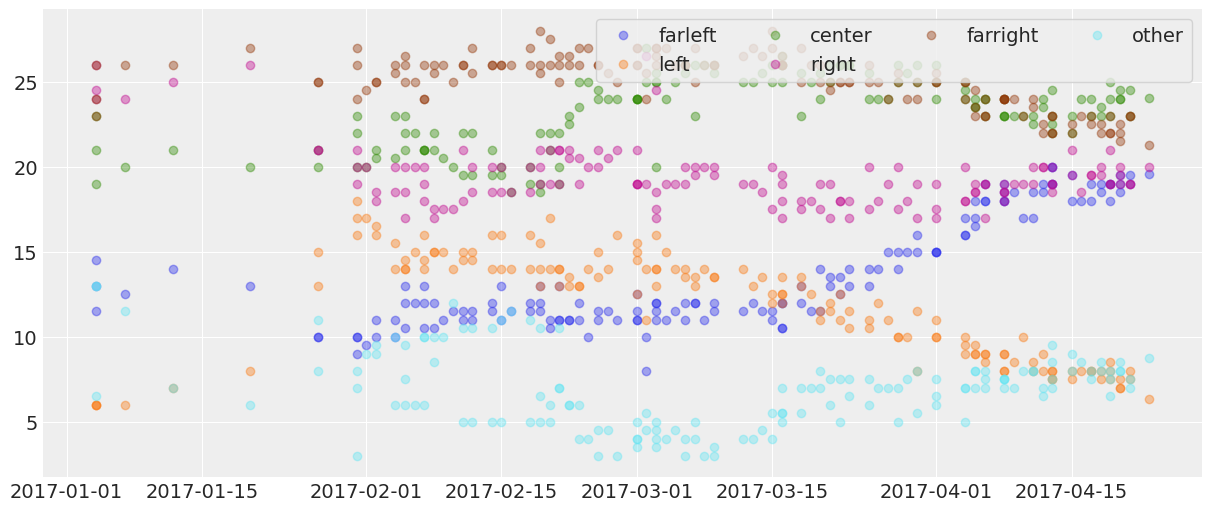

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
for p in COORDS["parties_complete"]:
    ax.plot(polls["date"], polls[p], "o", label=p, alpha=0.4)
ax.legend(ncol=4, frameon=True, loc="upper right");

In [7]:
# isolate results
results = polls[polls.sondage == "result"]
polls = polls[polls.sondage != "result"].set_index(["date", "sondage"])

In [8]:
# cast as multinomial obs
polls[COORDS["parties_complete"]] = (
    (polls[COORDS["parties_complete"]] / 100)
    .mul(polls["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()
polls

date sondage  samplesize  farleft  left  center  right  farright  \
0   2017-01-04   Elabe         996      144    60     229    259       239   
1   2017-01-04   Elabe         995      129    60     209    239       229   
2   2017-01-04    Ifop        1472      169    88     280    361       383   
3   2017-01-07     BVA         946      118    57     189    227       246   
4   2017-01-12   Ipsos       15919     2229  1114    3343   3980      4139   
..         ...     ...         ...      ...   ...     ...    ...       ...   
139 2017-04-20   Elabe        1196      233    84     287    239       257   
140 2017-04-20    Ifop        1901      352   133     466    370       428   
141 2017-04-20   Ipsos        1400      266   105     336    266       308   
142 2017-04-21     BVA        1134      221    91     261    215       261   
143 2017-04-21   Odoxa         667      127    50     163    127       153   

     other  
0       65  
1      129  
2      191  
3      109  
4     1114  
..     ...  
139     96  
140    152  
141    119  
142     85  
143     47  

[144 rows x 9 columns]

In [9]:
ELECTION_DAY = pd.to_datetime("2017-04-23")
# TEST_CUTOFF = ELECTION_DAY - pd.Timedelta(1, "W")
TEST_CUTOFF = ELECTION_DAY - pd.Timedelta(2, "D")
WHOLE_TIMELINE = pd.date_range(polls.date[0], ELECTION_DAY, freq="D")
polls_train = polls[polls.date <= TEST_CUTOFF]
polls_test = polls[polls.date > TEST_CUTOFF]

In [10]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "D")

    return np.asarray(t)

## GP approximation

In [11]:
def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)

    return np.eye(N) - 2 * np.outer(v, v)

In [12]:
def make_centered_gp_eigendecomp(
    time: np.ndarray,
    lengthscales: List[float],
    variance_limit: float = 0.95,
    metric: str = "euclidean",
    zerosum: bool = False,
):
    """
    Decompose the GP into eigen values and eigen vectors.

    Parameters
    ----------
    time: np.ndarray
        Array containing the time points of observations.
    lengthscales: List[float]
        Length scale parameter of the GP. Set in the ``config`` dictionary.
    variance_limit: float, defaults to 0.95
        Controls how many of the eigen vectors of the GP are used. So, if
        ``variance_limit=1``, all eigen vectors are used.
    metric: str, defaults to "euclidean"
        Experimental. Used to estimate the distance between ranges and rows.
    zerosum: bool, default=False
        Constrain all basis functions to sum(basis) = 0.

    Notes
    -----
    Makes sure that the GP effect sums to zero across plots of each field.
    """

    ## Construct covariance matrix
    X = time[:, None]
    X_norm = X / np.array(lengthscales)
    dists = spatial.distance.cdist(X_norm, X_norm, metric=metric)
    cov = np.exp(-(dists ** 2) / 2)

    if zerosum:
        Q = make_sum_zero_hh(len(cov))
        D = np.eye(len(cov))
        D[0, 0] = 0

        # 1) Transform the covariance matrix so that the first entry
        # is the mean: A = Q @ cov @ Q.T
        # 2) Project onto the subspace without the mean: B = D @ A @ D
        # 3) Transform the result back to the original space: Q.T @ B @ Q
        cov = Q.T @ D @ Q @ cov @ Q.T @ D @ Q

    vals, vecs = linalg.eigh(cov)
    n_eigs = ((vals[::-1].cumsum() / vals.sum()) > variance_limit).nonzero()[0][0]

    return vecs[:, -n_eigs:] * np.sqrt(vals[-n_eigs:])

In [13]:
observed_days_idx = dates_to_idx(polls_train.date).astype(int)
estimated_days = dates_to_idx(WHOLE_TIMELINE).astype(int)
pollster_id, pollsters = polls_train["sondage"].factorize(sort=True)

In [57]:
gp_basis = make_centered_gp_eigendecomp(
    estimated_days,
    lengthscales=9.0,
    variance_limit=0.99
)

In [58]:
COORDS["pollsters"] = pollsters
COORDS["observed_days"] = polls_train.date
COORDS["estimated_days"] = WHOLE_TIMELINE
COORDS["gp_basis"] = pd.RangeIndex(gp_basis.shape[-1])
COORDS["observations"] = polls_train.set_index(["date", "sondage", "samplesize"]).index

# Note: doesn't reassign green party
mean_prior_p = (
    arviz.from_netcdf("fundamentals_preds.nc")
    .posterior.mean(("samples", "regions"))
    .sel(parties_complete=COORDS["parties_complete"])["x"]
    .data
)
prior_cum_p = np.cumsum(mean_prior_p)
prior_logit_p = logit(prior_cum_p)[:-1]

    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )
    
    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

In [59]:
with pm.Model(coords=COORDS) as m:
    n_parties = len(COORDS["parties"])
    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=0.5)
    intercept_diffs = pm.HalfNormal(
        "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
    )
    intercepts = pm.Deterministic(
        "intercepts",
        aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
        dims="parties",
    )
    #    intercepts = pm.Normal(
    #       "intercepts",
    #      mu=prior_logit_p,
    #     sigma=0.5,
    #    initval=prior_logit_p,
    #   transform=pm.distributions.transforms.ordered,
    #  dims="parties",
    # )

    trend_base = pm.Normal("trend_base", mu=-1, sigma=0.15)
    trend_diffs = pm.HalfNormal("trend_diffs", sigma=1 / n_parties, shape=n_parties - 1)
    trends = pm.Deterministic(
        "long_term_trends",
        aet.concatenate([[trend_base], trend_base + trend_diffs.cumsum()]),
        dims="parties",
    )

    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.15)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )

    t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")
    cutpoints = pm.Deterministic(
        "cutpoints",
        intercepts + aet.dot(t[:, None], trends[None, :]) + ordered_gps,
        dims=("estimated_days", "parties"),
    )

    bias = pm.Normal("bias", 0, 0.15, dims="pollsters")

    pm.OrderedMultinomial(
        "results",
        eta=bias[pollster_id],
        cutpoints=cutpoints[observed_days_idx],
        n=polls_train["samplesize"].values,
        observed=polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

In [62]:
with m:
    idata = pm.sample(
        random_seed=RANDOM_SEED,
        tune=2000,
        draws=2000,
        target_accept=0.99,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_base, intercept_diffs, trend_base, trend_diffs, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1615 seconds.


0, dim: observations, 144 =? 144


In [63]:
arviz.summary(
    idata,
    var_names=["~time_effect", "~results_probs"],
    filter_vars="regex",
    round_to=2,
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept_base     -1.65  0.11   -1.85    -1.43        0.0      0.0   4867.97   
intercept_diffs[0]  0.05  0.04    0.00     0.12        0.0      0.0   8145.23   
intercept_diffs[1]  0.45  0.06    0.33     0.57        0.0      0.0   4923.06   
intercept_diffs[2]  0.51  0.04    0.44     0.59        0.0      0.0   6495.31   
intercept_diffs[3]  1.18  0.11    0.97     1.39        0.0      0.0   4028.56   
...                  ...   ...     ...      ...        ...      ...       ...   
cutpoints[109,0]   -1.58  0.06   -1.69    -1.46        0.0      0.0   4818.15   
cutpoints[109,1]   -1.09  0.06   -1.20    -0.97        0.0      0.0   4625.87   
cutpoints[109,2]   -0.02  0.06   -0.14     0.09        0.0      0.0   4485.36   
cutpoints[109,3]    0.81  0.06    0.71     0.93        0.0      0.0   4438.27   
cutpoints[109,4]    2.44  0.06    2.32     2.55        0.0      0.0   4708.37   

                    ess_tail  r_hat  
intercept_base       5152.04    1.0  
intercept_diffs[0]   4417.03    1.0  
intercept_diffs[1]   4722.98    1.0  
intercept_diffs[2]   4608.48    1.0  
intercept_diffs[3]   4004.41    1.0  
...                      ...    ...  
cutpoints[109,0]     5317.03    1.0  
cutpoints[109,1]     5072.32    1.0  
cutpoints[109,2]     5088.95    1.0  
cutpoints[109,3]     5511.96    1.0  
cutpoints[109,4]     5559.43    1.0  

[1183 rows x 9 columns]

In [64]:
arviz.summary(idata, "time_effect", filter_vars="regex", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    3928.0
ess_tail    4224.0
dtype: float64

In [65]:
arviz.summary(idata, "results_probs", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    7335.0
ess_tail    5468.0
dtype: float64

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_ess, generating only 40 plots
  warnings.warn(


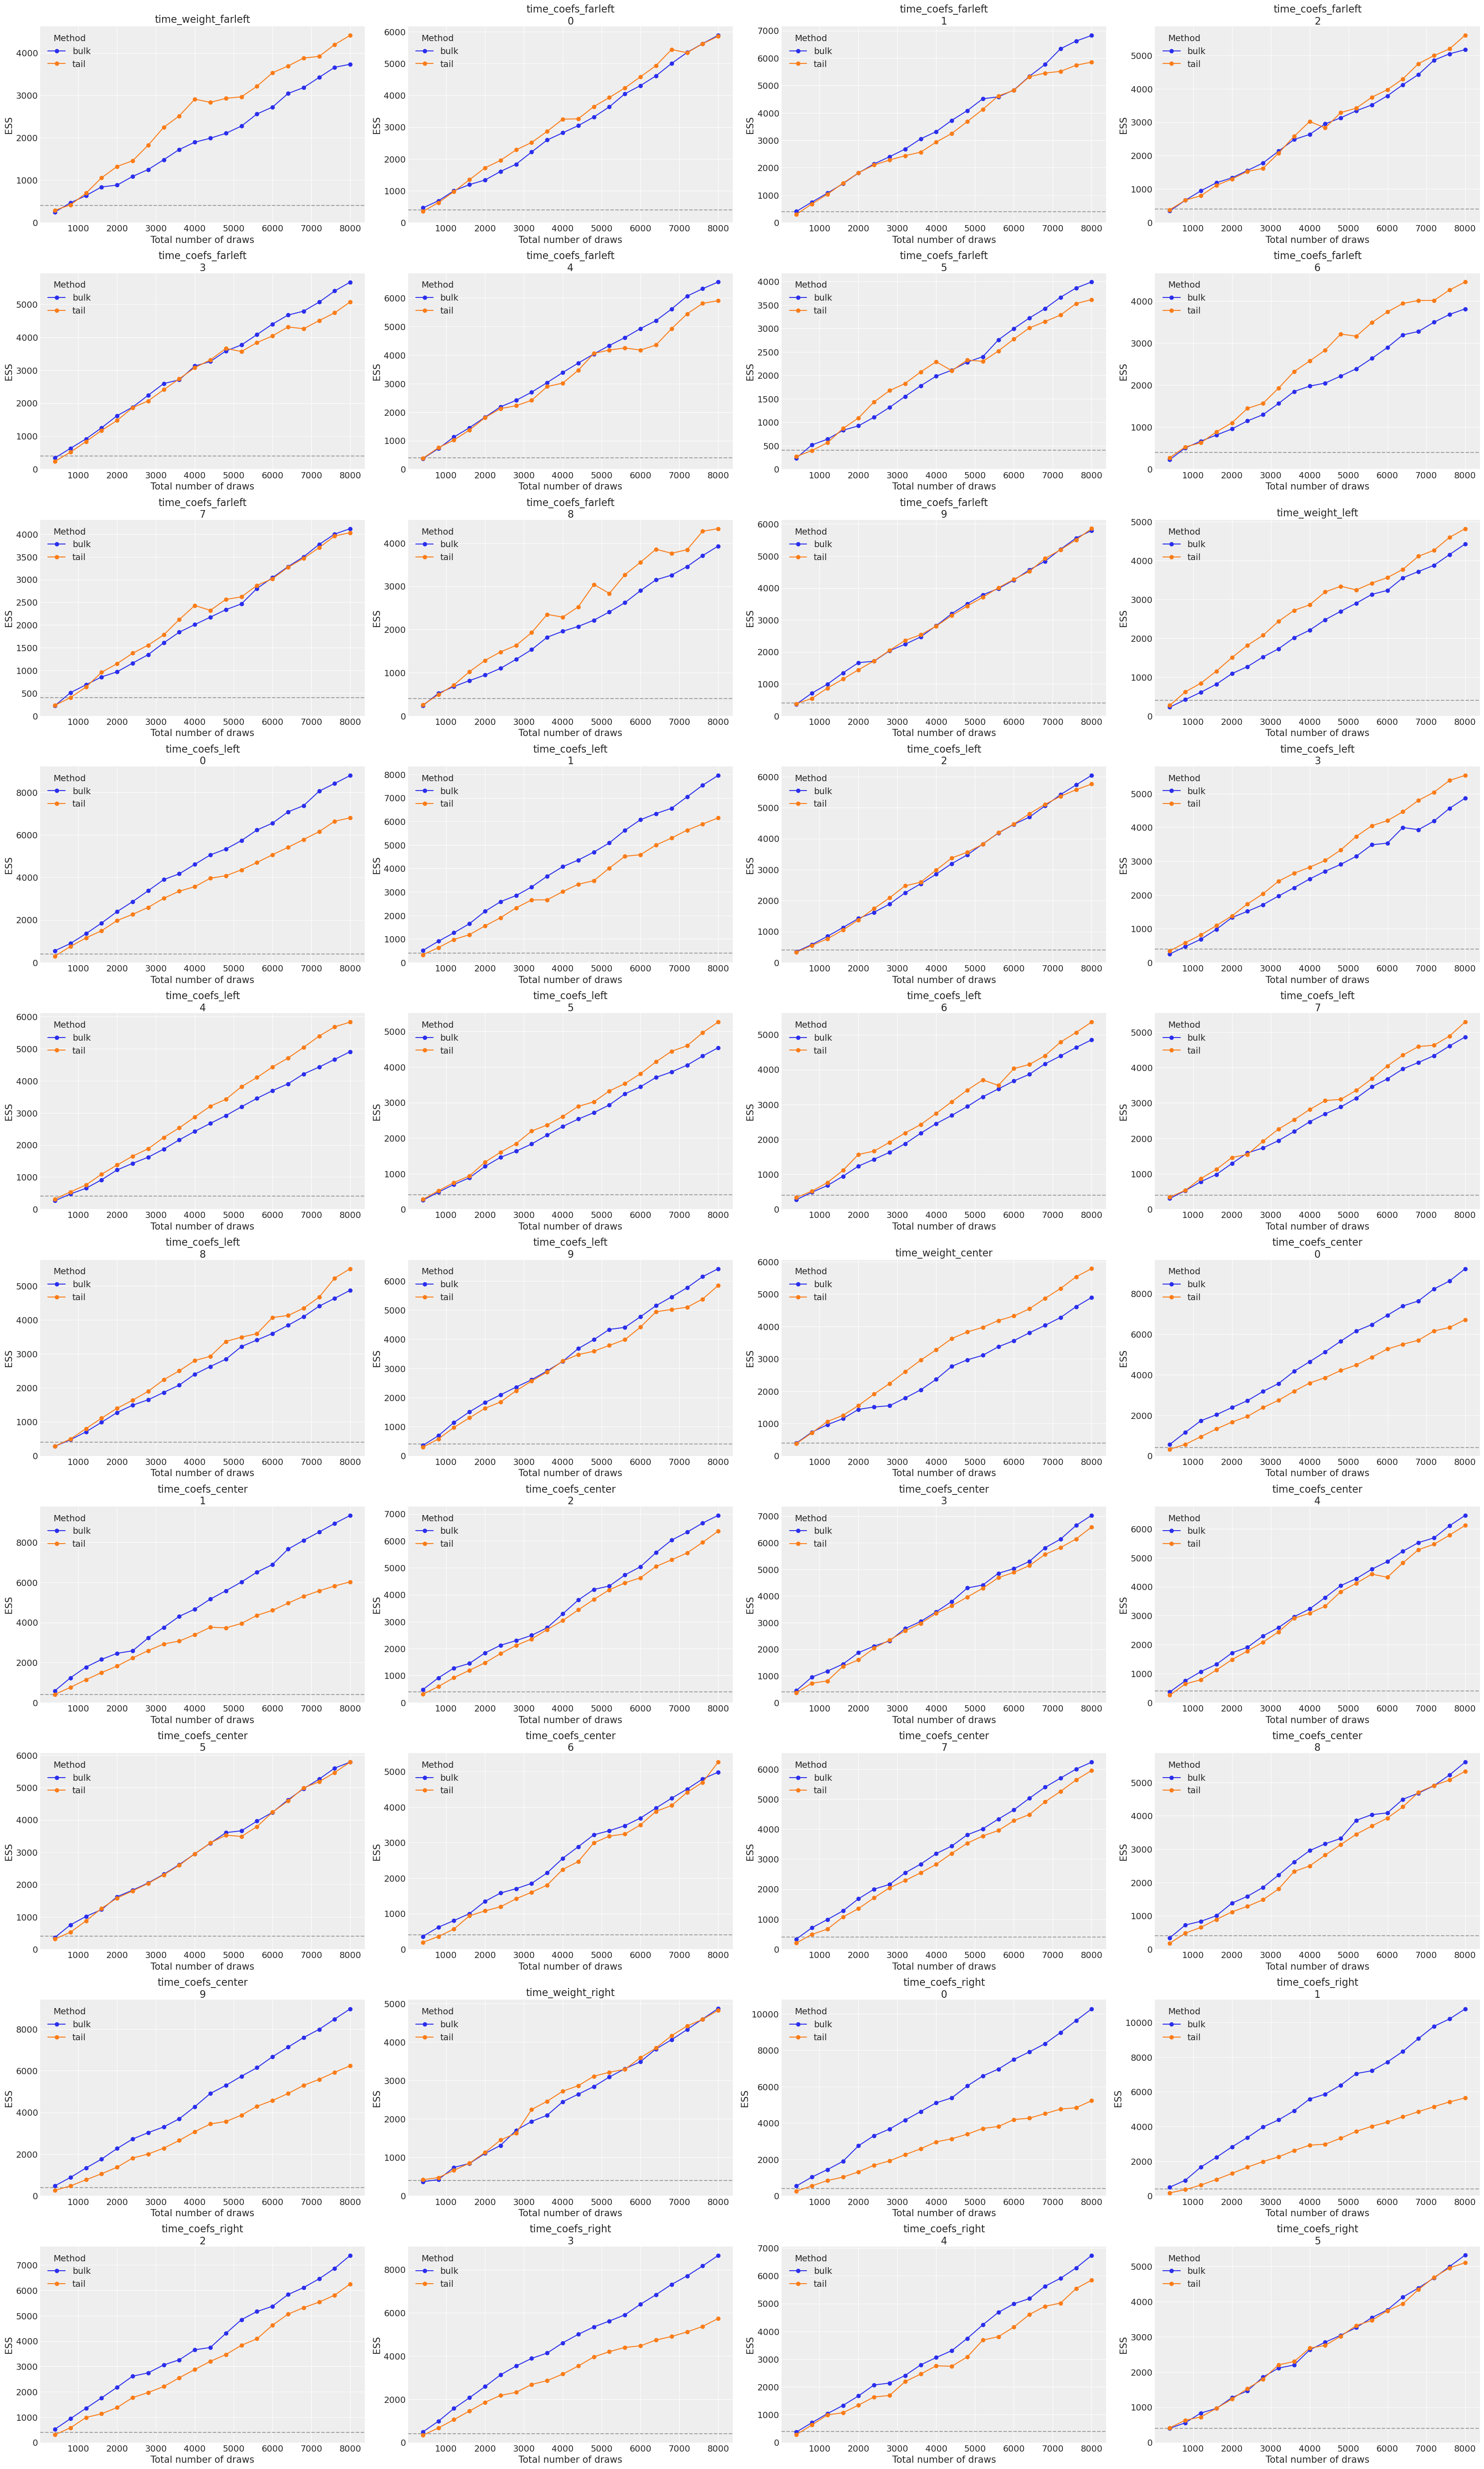

In [66]:
arviz.plot_ess(
    idata,
    kind="evolution",
    var_names=["_weight", "_coefs"],
    filter_vars="regex",
);

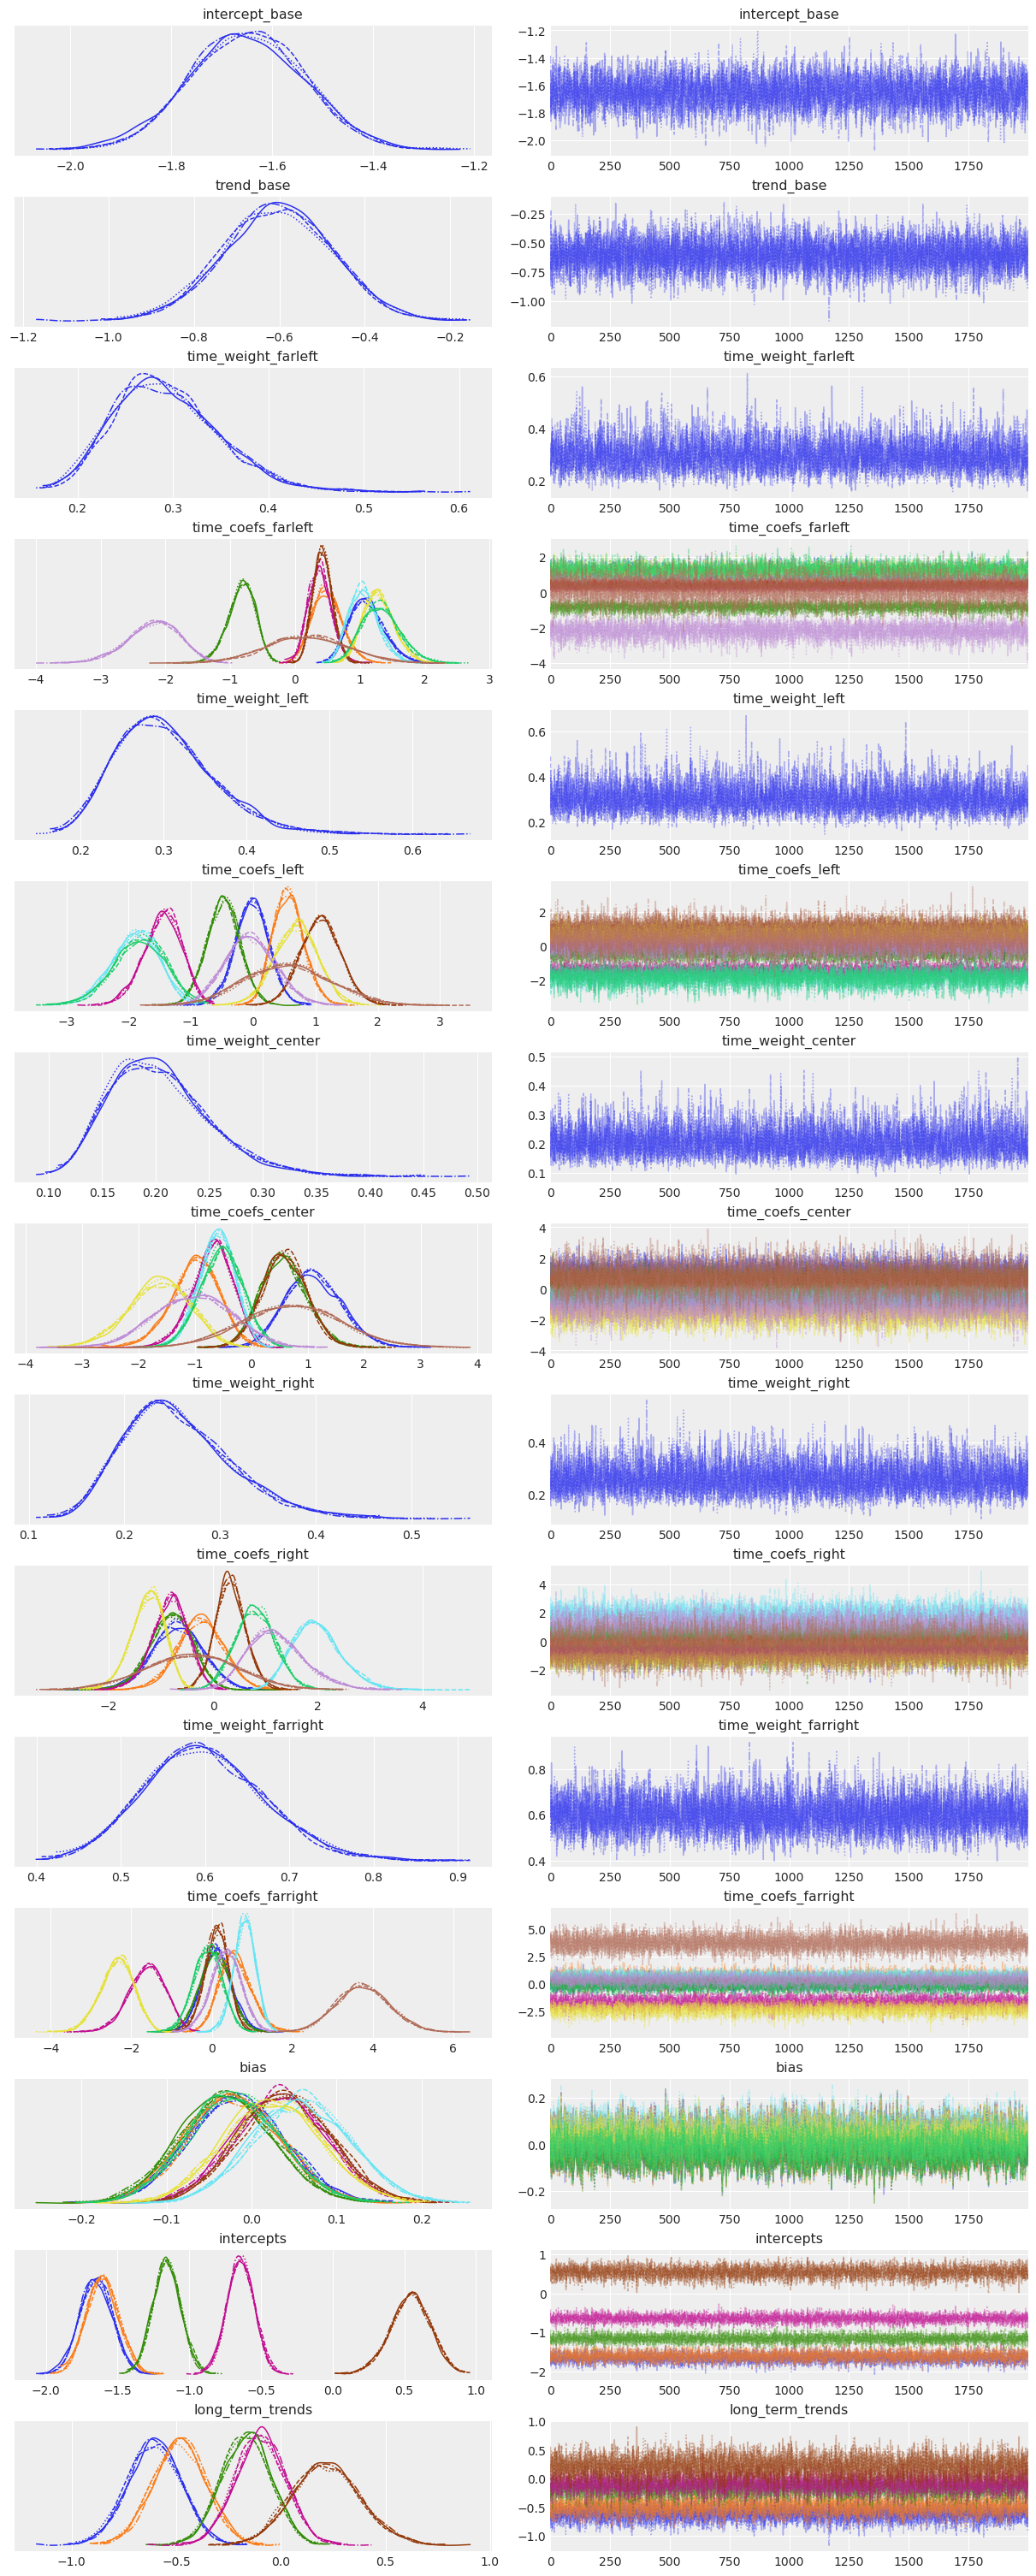

In [67]:
arviz.plot_trace(
    idata,
    var_names=[
        "~cutpoints",
        "~_diffs",
        "~_effect",
        "~ordered_",
        "~results_probs",
    ],
    filter_vars="regex",
);

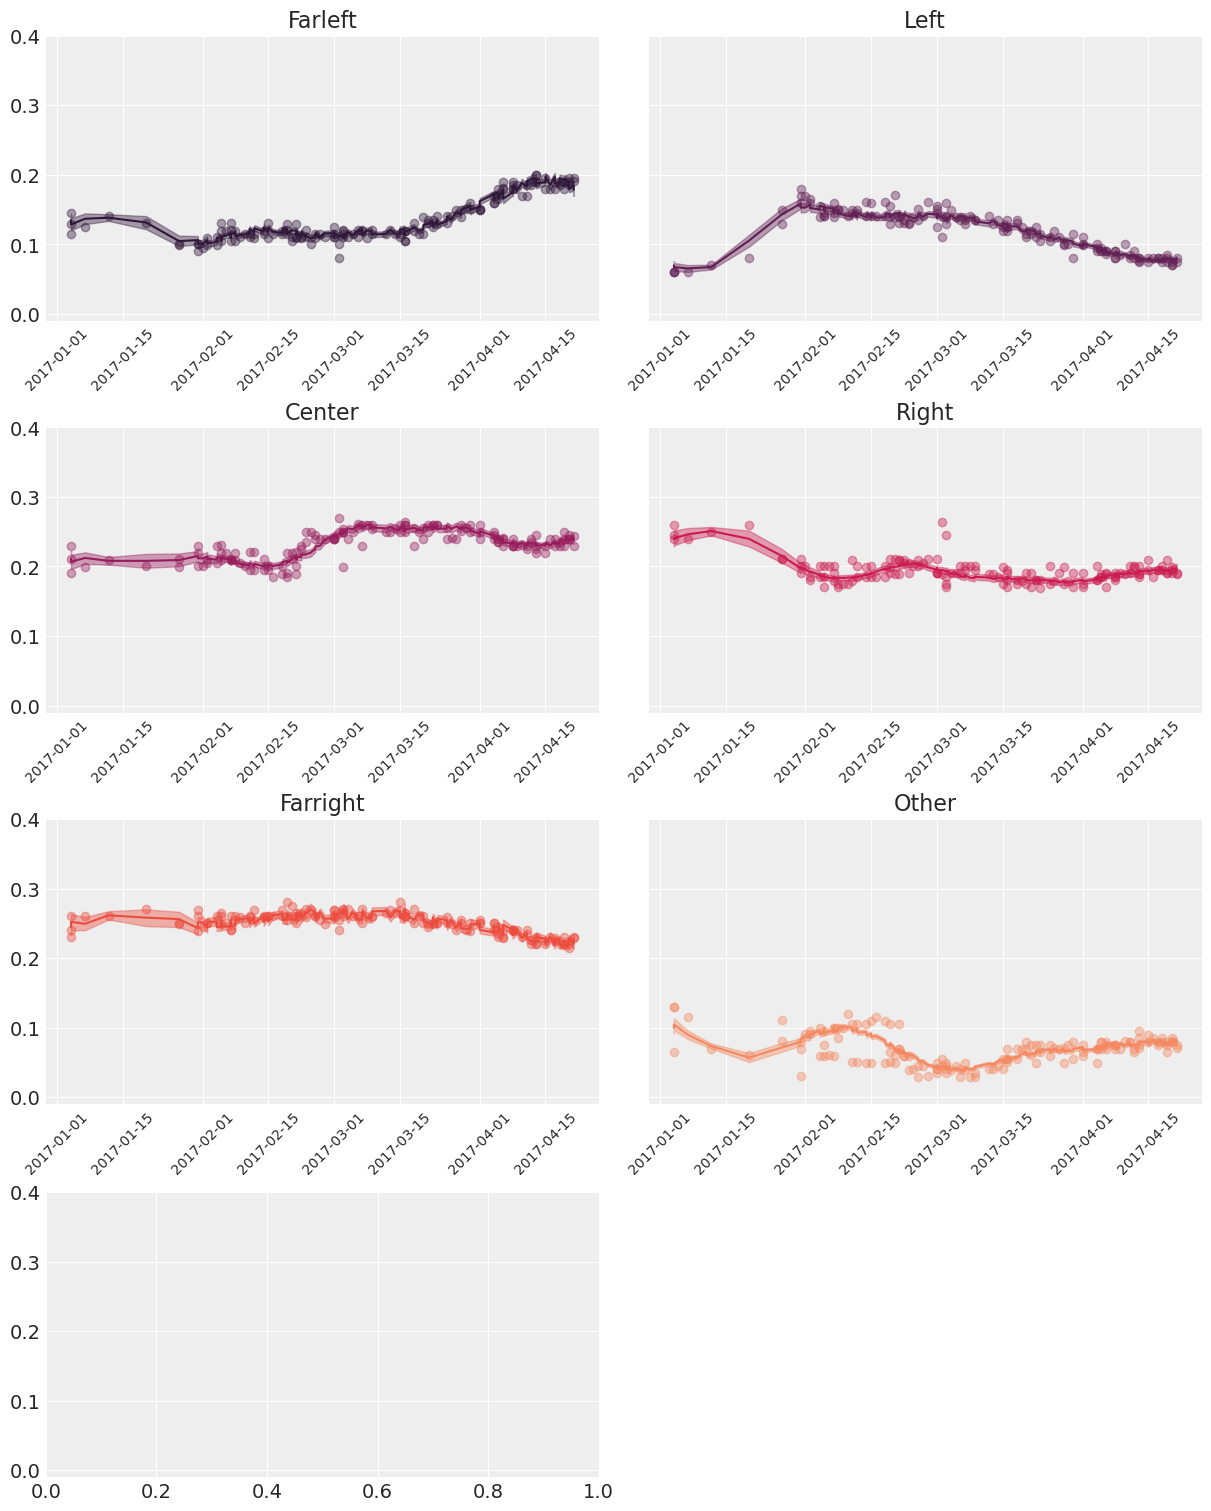

In [68]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
axes = axes.ravel()
axes[-1].remove()
colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

post_means = idata.posterior["results_probs"].mean(("chain", "draw"))
hdi = arviz.hdi(idata.posterior)

for i, p in enumerate(COORDS["parties_complete"]):
    axes[i].plot(
        polls_train["date"],
        polls_train[p] / polls_train["samplesize"],
        "o",
        color=colors[i],
        alpha=0.4,
    )
    axes[i].fill_between(
        polls_train["date"],
        hdi.sel(parties_complete=p, hdi="lower")["results_probs"],
        hdi.sel(parties_complete=p, hdi="higher")["results_probs"],
        color=colors[i],
        alpha=0.4,
    )
    axes[i].plot(
        polls_train["date"], post_means.sel(parties_complete=p), color=colors[i]
    )
    axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
    axes[i].set(title=p.title(), ylim=(-0.01, 0.4))

## Out-of-sample predictions

In [ ]:
trend = pm.Normal("long_term_trends")
t = pm.Data("t", observed_days_idx / observed_days_idx.max(), dims="observations")
eta = pm.Deterministic("eta", trend * t, dims="observations")

In [ ]:
t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")

cutpoints = pm.Deterministic(
    "cutpoints",
    intercepts + aet.dot(t[:, None], trends[None, :]) + ordered_gps,
    dims=("estimated_days", "parties"),
)

bias = pm.Normal("bias", 0, 0.15, dims="pollsters")

In [69]:
p_cum = logistic(idata.posterior["cutpoints"]).data
# post_eta = np.dot(trace_simple.posterior["long_term_trends"].data[..., None], estimated_days[None, ...])[..., None]
# p_cum = logistic(trace_simple.posterior["cutpoints"].data - post_eta)
p_cum = np.c_[
    np.zeros_like(p_cum[..., 0][..., None]),
    p_cum,
    np.ones_like(p_cum[..., 0][..., None]),
]
post_probs = xarray.DataArray(
    p_cum[..., 1:] - p_cum[..., :-1],
    dims=["chain", "draw", "estimated_days", "parties_complete"],
    coords={
        "chain": idata.posterior["chain"],
        "draw": idata.posterior["draw"],
        "estimated_days": idata.posterior["estimated_days"],
        "parties_complete": idata.posterior["parties_complete"],
    },
)

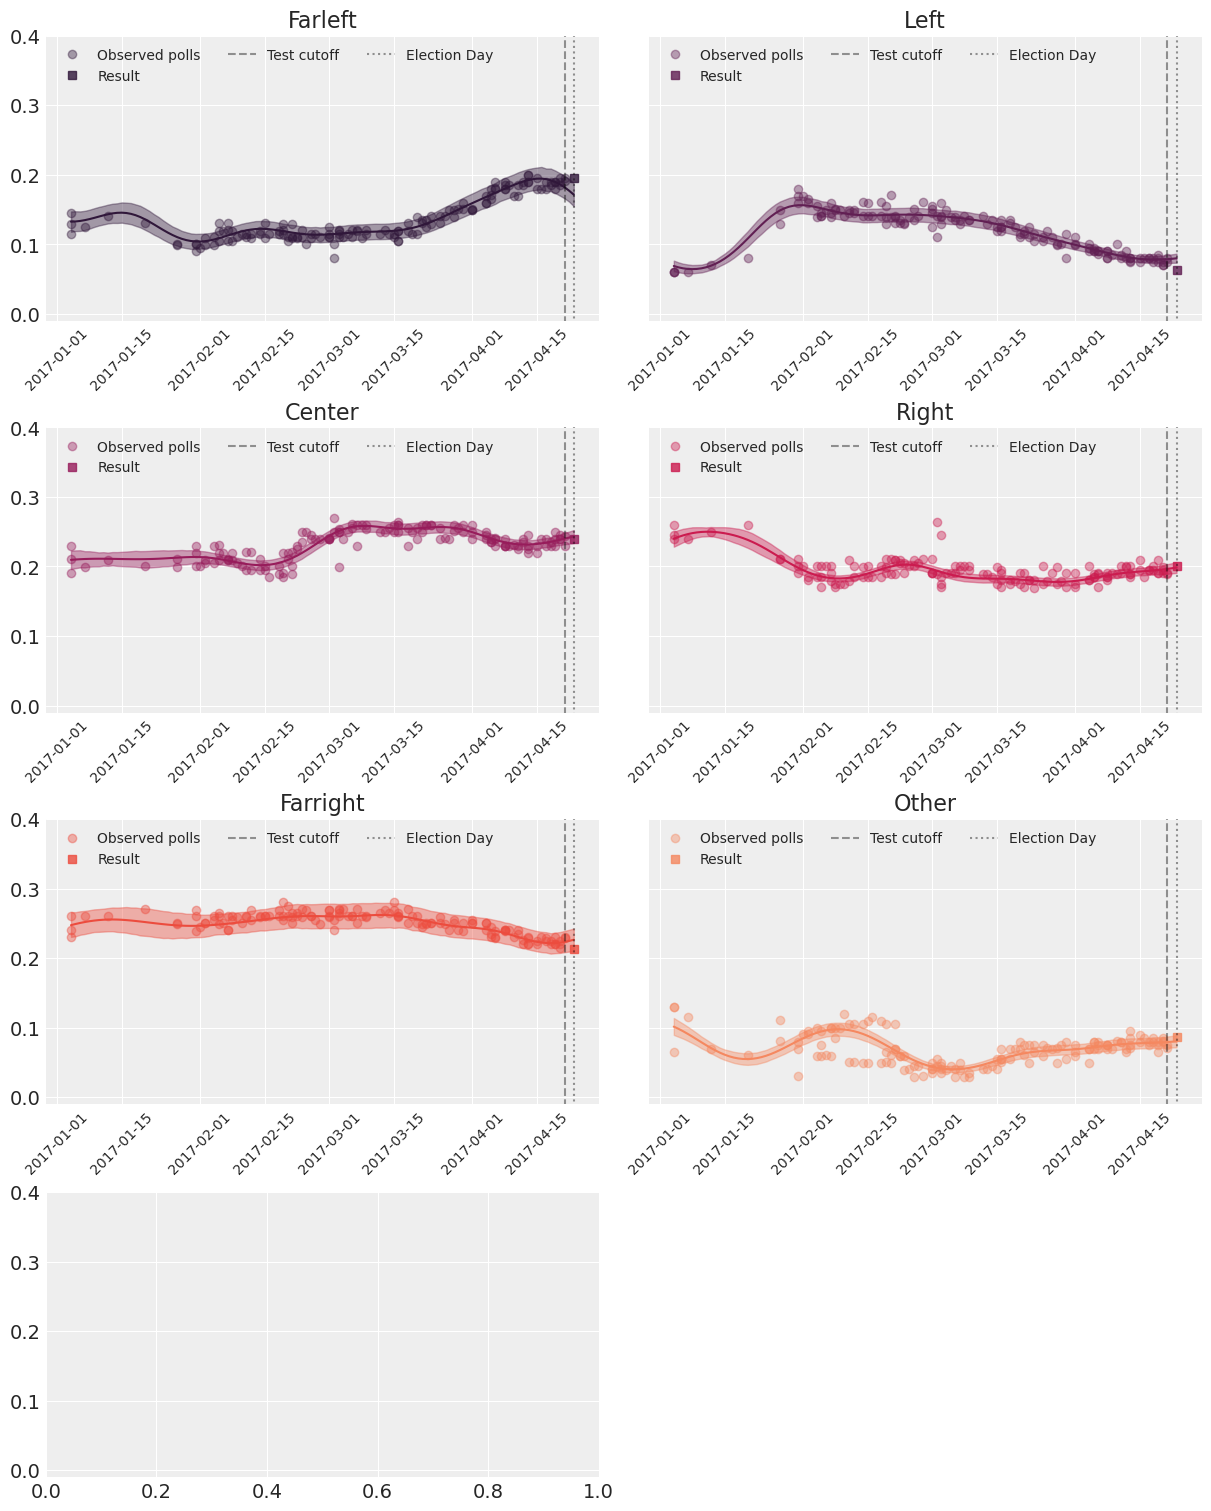

In [70]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
axes = axes.ravel()
axes[-1].remove()
colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

post_means = post_probs.mean(("chain", "draw"))
hdi = arviz.hdi(post_probs)

for i, p in enumerate(COORDS["parties_complete"]):
    axes[i].plot(
        polls_train["date"],
        polls_train[p] / polls_train["samplesize"],
        "o",
        color=colors[i],
        alpha=0.4,
        label="Observed polls",
    )
    if not polls_test.empty:
        axes[i].plot(
            polls_test["date"],
            polls_test[p] / polls_test["samplesize"],
            "x",
            color="red",
            alpha=0.4,
            label="Unobserved polls",
        )
    axes[i].plot(
        ELECTION_DAY, results[p] / 100, "s", color=colors[i], alpha=0.8, label="Result"
    )
    axes[i].fill_between(
        post_probs["estimated_days"],
        hdi.sel(parties_complete=p, hdi="lower")["x"],
        hdi.sel(parties_complete=p, hdi="higher")["x"],
        color=colors[i],
        alpha=0.4,
    )
    axes[i].plot(
        post_probs["estimated_days"],
        post_means.sel(parties_complete=p),
        color=colors[i],
    )
    axes[i].axvline(
        x=TEST_CUTOFF,
        ymin=-0.01,
        ymax=1.0,
        ls="--",
        c="k",
        alpha=0.4,
        label="Test cutoff",
    )
    axes[i].axvline(
        x=ELECTION_DAY,
        ymin=-0.01,
        ymax=1.0,
        ls=":",
        c="k",
        alpha=0.4,
        label="Election Day",
    )
    axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
    axes[i].set(title=p.title(), ylim=(-0.01, 0.4))
    axes[i].legend(fontsize=10, ncol=3)

In [ ]:
# read theory about ordinal regression
# prior pred checks
# biases ZeroSum
# overdispersion
# add popularity as predictor. And an econ variable?
# plain multinomial?